# Data Project 2021: School performance across Danish municipalities

The aim of the data project is to investigate primary school performance across Danish municipalities based on the grade point average obtained by the students at the final exam. We fetch data for performance of primary schools from the Danish Ministry of Children and Education. Futhermore, we fetch data from Statistics Denmark covering average income levels and shares of hihgly educated inhabitants in the Danish muncipalities. First, we read and clean the data sets in order to merge them into a single DataFrame. Then, we analyze the data  and investigate whether there is positive correlation between income and education levels and the performance of primary schools across municipalities.

**The project is organized as follows:**

1. Data project description
2. Reading and cleaning data
3. Merging data
4. Data analysis
5. Conclusion

**Group:** SSTL

**Members:** Louise Otte Arildsen (srb330), Signe Kolind (hmk792), Stine Fürst (qvj635) & Thomas Nielsen (qzw392)

**Imports and set magics:**

In [148]:
import pandas as pd
import pandas_datareader # install with `pip install pandas-datareader`
import pydst # install with `pip install git+https://github.com/elben10/pydst`
import matplotlib.pyplot as plt
import geopandas as gpd #
import descartes #!pip install descartes
import seaborn as sns
import ipywidgets as widgets
# autoreload modules when code is run
%load_ext autoreload
%autoreload 2
import numpy as np
import datetime
plt.style.use('seaborn-whitegrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and clean data



## School performance data

**Reading and cleaning the data**

We read the school data in Skoletal.xlsx obtained from education statistics conducted by the Danish Ministry of Children and Education. The data set contains key indicators of performance for the primary schools in Denmark at municpality level. We clean the data by removing redundant columns and renaming the columns:

In [149]:
# read the excel file using pandas, therefore creating an dataframe. 
school = pd.read_excel('Skoletal.xlsx', skiprows=2)

# b. drop columns
drop_these = ['Rækkenavne', 'Overgang 15 mdr ungdomsuddannelse fra 9 og 10 kl', 'Signifikant forskel', 'Forskel', 'Kompetencedækning', 'Elevtal']
school.drop(drop_these, axis=1, inplace=True)

# c. rename columns
school.rename(columns = {'Institution':'school', 'Skoleår':'year', 
                         'Karaktergennemsnit_skoletal':'gpa', 'Socioøkonomisk reference':'socioeconomic', 
                         'Andel med højest trivsel':'well-being', 'Samlet elevfravær':'absence', 'Klassekvotient':'students_per_class'}, inplace=True)
# d. rename danish names in rows
school['year'] = school['year'].replace({'København':'Copenhagen'}) #renaming København to Copenhagen

In [150]:
print('The data set now looks like this:')
school.head()

The data set now looks like this:


,school,year,gpa,socioeconomic,well-being,absence,students_per_class
0,Den Classenske Legatskole,2013/2014,8.2,7.8,NaN,NaN,24.95
1,Den Classenske Legatskole,Copenhagen,8.2,7.8,NaN,NaN,24.95
2,Den Classenske Legatskole,2014/2015,7.6,7.5,0.906615,0.089829,24.90
3,Den Classenske Legatskole,Copenhagen,7.6,7.5,0.906615,0.089829,24.90
4,Den Classenske Legatskole,2015/2016,8.2,8.0,0.956044,0.079799,24.90


**Seperate municipality and school year in column 'year':**

In the data set every row is duplicated such that the data is the same in every column except from in column 'year'. The column 'year' alternately displays school year and municipality and we want to split this into two seperate columns.

In [151]:
print(f'The number of rows in data set school is = {len(school)}')

#Then we create a new variable 'municipality', which extract all muncipality names from 'year' using iloc
municipality=pd.DataFrame(school['year'].iloc[1::2].values)

#We check that the number of municipality names are equal to half of the row lines. 
print(f'31328 divided by 2 = {len(school)/2}')
print(f'The number of rows in data set municipality is = {len(municipality)}')

#Then we delete every other row (the ones containing municipalities in the column 'year'
res = [True, False] * 15664 # every uneven number in an index will be removed in a dataset
school_new=school[res] # attaching to the dataframe
school_new.reset_index(drop=True, inplace=True) # resets the index, so ID=0,1,2,N instead of ID=0,2,4,6,N
print(f'The number of rows in dataset school_new is = {len(school_new)}')

#We then concatenate school_new with municipalities and arrive at the solution
school_final = pd.concat([school_new, municipality], axis=1) 
school_final.rename(columns = {school_final.columns[7]:'municipality'}, inplace=True)

The number of rows in data set school is = 31328
31328 divided by 2 = 15664.0
The number of rows in data set municipality is = 15664
The number of rows in dataset school_new is = 15664


In [152]:
print('The data set now looks like this:')
school_final.head()

The data set now looks like this:


,school,year,gpa,socioeconomic,well-being,absence,students_per_class,municipality
0,Den Classenske Legatskole,2013/2014,8.2,7.8,NaN,NaN,24.95,Copenhagen
1,Den Classenske Legatskole,2014/2015,7.6,7.5,0.906615,0.089829,24.90,Copenhagen
2,Den Classenske Legatskole,2015/2016,8.2,8.0,0.956044,0.079799,24.90,Copenhagen
3,Den Classenske Legatskole,2016/2017,7.8,7.8,0.913669,0.072769,25.60,Copenhagen
4,Den Classenske Legatskole,2017/2018,8.8,8.1,0.919540,0.081672,24.80,Copenhagen


**We decide to only investigate the year 2018/2019, because it is the latest year with data without any corona effect, and rename it to 2019:**

In [153]:
#renaming the years
school_final["year"].replace({"2018/2019": "2019", "2019/2020": "2020"}, inplace=True)

#function to only keep 2019 data observations
def only_keep_oneyear(df):
    """ delete all year except 2019
    Args:
        df (pd.DataFrame): pandas dataframe with the column "year" as a string

    Returns:
        df (pd.DataFrame): pandas dataframe

    """ 
    for val in ['2019']:
        
        I = df.year.str.contains(val)
        df = df.loc[I == True] # keep everything else
    
    return df
school = only_keep_oneyear(school_final)
school.reset_index(drop=True, inplace=True)

print('The data set now looks like this:')
school.head()

The data set now looks like this:


,school,year,gpa,socioeconomic,well-being,absence,students_per_class,municipality
0,Den Classenske Legatskole,2019,7.5,7.6,0.900000,0.071541,24.75,Copenhagen
1,Nyboder Skole,2019,8.0,7.8,0.950495,0.073004,22.40,Copenhagen
2,Sølvgades Skole,2019,7.4,7.6,0.901961,0.071107,23.45,Copenhagen
3,Nørrebro Park Skole,2019,5.3,5.5,0.950331,0.069968,24.40,Copenhagen
4,Blågård Skole,2019,4.2,5.0,0.876923,0.079616,21.32,Copenhagen


**Data set 1: School data**

This data set we just arrived at covers school performance across all primary schools in Denmark in 2019. 

Variable      | Description
------------- | -------------
school        | School name
gpa           | Grade point average
socioeconomic          | Predicted gpa based on socioeconomic factors
well-being           | Pct. share of students with the highest level of well-being
absence | Total absence across students

We will use this data set in the data analysis to investigate primary school performance on school level, but we also want to investigate school performance on municipality level and therefor create a new data set with the average gpa of all primary schools in a municipality. This data set will later be merged with data set for average income and educational level across municipalities to create our second data set.

**Data set 1 with gpa mean across muncipalities in 2019**

In [154]:
#group by municipality and calculate mean of gpa
school_merge=school.groupby(['municipality'])['gpa'].mean().reset_index(name='gpa')
school_merge.head()

,municipality,gpa
0,Aabenraa,6.127814
1,Aalborg,7.013712
2,Aarhus,7.140788
3,Albertslund,6.063983
4,Allerød,7.965370


We notice that 'Christiansø' is a part of our dataset. Christiansø is not a Danish municipality, hence it is removed from our data.

In [155]:
school_merge=school_merge.groupby(by="municipality").sum()
school_merge = school_merge.drop("Christiansø", axis=0).reset_index()
school_merge.head()

,municipality,gpa
0,Aabenraa,6.127814
1,Aalborg,7.013712
2,Aarhus,7.140788
3,Albertslund,6.063983
4,Allerød,7.965370


## Income data

We use the module pydst to extract data from Danmarks statistik. This package is designed specifically for this website in order to easily obtain all data. The architecture of the package itself is unknown, and if data from other sites is requested, then the package request would be suitable instead with a more manual approach to API scrapping. 

In [156]:
Dst = pydst.Dst(lang='en') # setup data loader with the langauge 'english'
Dst.get_subjects(); # Desc: Identifies all the sub statistics within Statistics Denmark with an ID attached. 
#Remove ';' to view output.

We are interested in income data. The above desc leads us to ID=04, where the sub area of interest is INDKP101

In [157]:
tables = Dst.get_tables(subjects=['04'])
tables[tables.id == 'INDKP101'];

We create a function that reveals information of the different variable id's, contained in data INDKP101
. Remove '#' to view output. 

In [158]:
#indk_vars = Dst.get_variables(table_id='INDKP101')
#display(indk_vars)
#for id in ['OMRÅDE','ENHED','KOEN','INDKOMSTTYPE','Tid']:
    #print(id)
    #values = indk_vars.loc[indk_vars.id == id,['values']].values[0,0]
    #for value in values:      
        #print(f' id = {value["id"]}, text = {value["text"]}')

The variables in INDKP101 are 'OMRÅDE','ENHED','KOEN','INDKOMSTTYPE','Tid'. Not all of them are relevant our analysis, hence they are restricted as much as possible. 

- OMRÅDE=*, all areas are relevant. 
- ENHED=116, Average income for all people (DKK). 
- KOEN=MOK, Both genders included. 
- INDKOMSTTYPE=105, Pre-tax Income, total. 
- TID=2019.

In [159]:
variables1 = {'OMRÅDE':['*'],'ENHED':['116'],'KOEN':['MOK'],'INDKOMSTTYPE':['105'], 
             'Tid':['2019']}
inc_api = Dst.get_data(table_id = 'INDKP101', variables=variables1)
inc_api.head()

,OMRÅDE,ENHED,KOEN,INDKOMSTTYPE,TID,INDHOLD
0,All Denmark,Average income for all people (DKK),"Men and women, total","2 Pre-tax Income, total (3+7+22+26+29)",2019,338122
1,Province Byen København,Average income for all people (DKK),"Men and women, total","2 Pre-tax Income, total (3+7+22+26+29)",2019,353203
2,Province Københavns omegn,Average income for all people (DKK),"Men and women, total","2 Pre-tax Income, total (3+7+22+26+29)",2019,388125
3,Province Nordsjælland,Average income for all people (DKK),"Men and women, total","2 Pre-tax Income, total (3+7+22+26+29)",2019,414861
4,Province Bornholm,Average income for all people (DKK),"Men and women, total","2 Pre-tax Income, total (3+7+22+26+29)",2019,291198


Columns 'KOEN', 'INDKOMSTTYPE', 'ENHED' and 'TID' are dropped since they are not relevant for our analysis.

In [160]:
inc_1=inc_api.drop(['KOEN','INDKOMSTTYPE','ENHED', 'TID'], axis=1)
inc_1.rename(columns = {'INDHOLD':'avg_income','OMRÅDE':'municipality'}, inplace=True) #renaming columns
print('Income data now looks like this:')
inc_1.head()

Income data now looks like this:


,municipality,avg_income
0,All Denmark,338122
1,Province Byen København,353203
2,Province Københavns omegn,388125
3,Province Nordsjælland,414861
4,Province Bornholm,291198


As noticed in above dataframe the data is not sorted. 
Hence the dataframe is grouped by municipality as of alphabetic order. 

In [161]:
avg_inc=inc_1.groupby(by="municipality").sum().reset_index()
print('Final income data now looks like this:')
avg_inc.head()

Final income data now looks like this:


,municipality,avg_income
0,Aabenraa,305855
1,Aalborg,310886
2,Aarhus,327869
3,Albertslund,295184
4,All Denmark,338122


## Education Level data

In [162]:
# List all subjects.
Dst.get_subjects()

# List all tables under the subject Education and knowledge which has the id 03\n",
table = Dst.get_tables(subjects=['03'])

#Choose the table \"HFUDD11: Befolkningens højest fuldførte uddannelse (15-69 år) efter bopælsområde, herkomst, højest fuldførte uddannelse, alder og køn\"\n",
table[table.id == 'HFUDD11']

# Get the variables in the dataset HFUDD11\n",
Edd_vars = Dst.get_variables(table_id='HFUDD11')
Edd_vars

# List all the ID of the of variable in the dataset HFUDD11:\n",
Edd_vars = Dst.get_variables(table_id='HFUDD11')
for id in ['BOPOMR','HERKOMST','HFUDD','Tid','ALDER']:
    print(id)
    values = Edd_vars.loc[Edd_vars.id == id,['values']].values[0,0]
    for value in values:      
        print(f' id = {value["id"]}, text = {value["text"]}')

BOPOMR
 id = 000, text = All Denmark
 id = 084, text = Region Hovedstaden
 id = 101, text = Copenhagen
 id = 147, text = Frederiksberg
 id = 155, text = Dragør
 id = 185, text = Tårnby
 id = 165, text = Albertslund
 id = 151, text = Ballerup
 id = 153, text = Brøndby
 id = 157, text = Gentofte
 id = 159, text = Gladsaxe
 id = 161, text = Glostrup
 id = 163, text = Herlev
 id = 167, text = Hvidovre
 id = 169, text = Høje-Taastrup
 id = 183, text = Ishøj
 id = 173, text = Lyngby-Taarbæk
 id = 175, text = Rødovre
 id = 187, text = Vallensbæk
 id = 201, text = Allerød
 id = 240, text = Egedal
 id = 210, text = Fredensborg
 id = 250, text = Frederikssund
 id = 190, text = Furesø
 id = 270, text = Gribskov
 id = 260, text = Halsnæs
 id = 217, text = Helsingør
 id = 219, text = Hillerød
 id = 223, text = Hørsholm
 id = 230, text = Rudersdal
 id = 400, text = Bornholm
 id = 411, text = Christiansø
 id = 085, text = Region Sjælland
 id = 253, text = Greve
 id = 259, text = Køge
 id = 350, text 

In [163]:
# Using the IDs from the previous table we get the data
variables_2 = {'BOPOMR':['*'],'HERKOMST':['*'],'HFUDD':['H10','H20','H30','H40','H50','H60','H70','H80'],'Tid':['*'],'KØN':['*'],'ALDER':['TOT']}
edu_api = Dst.get_data(table_id = 'HFUDD11', variables=variables_2)
edu_api.head()

,BOPOMR,HERKOMST,HFUDD,TID,KØN,ALDER,INDHOLD
0,Haderslev,Persons of Danish origin,H80 PhD programs,2008,Women,"Age, total",5
1,Haderslev,Persons of Danish origin,H80 PhD programs,2008,Men,"Age, total",15
2,Haderslev,Persons of Danish origin,H80 PhD programs,2008,Total,"Age, total",20
3,Billund,Total,H10 Primary education,2008,Women,"Age, total",3565
4,Billund,Total,H10 Primary education,2008,Men,"Age, total",3489


In [164]:
#Drop colum ALDER and KØN
drop_these = ['ALDER','KØN', 'TID']
edu_api.drop(drop_these ,axis=1,inplace=True)
edu_api.head(5)

,BOPOMR,HERKOMST,HFUDD,INDHOLD
0,Haderslev,Persons of Danish origin,H80 PhD programs,5
1,Haderslev,Persons of Danish origin,H80 PhD programs,15
2,Haderslev,Persons of Danish origin,H80 PhD programs,20
3,Billund,Total,H10 Primary education,3565
4,Billund,Total,H10 Primary education,3489


In [165]:
#Translate the names of the variable to english
edu_api.rename(columns={'BOPOMR':'municipality','HERKOMST':'origin','TID':'year','HFUDD':'education','INDHOLD':'number of individuals'},inplace=True)
edu_api.head(5)

,municipality,origin,education,number of individuals
0,Haderslev,Persons of Danish origin,H80 PhD programs,5
1,Haderslev,Persons of Danish origin,H80 PhD programs,15
2,Haderslev,Persons of Danish origin,H80 PhD programs,20
3,Billund,Total,H10 Primary education,3565
4,Billund,Total,H10 Primary education,3489


In [166]:
# Using the IDs from the previous table we get the data
variables_2 = {'BOPOMR':['*'],'HERKOMST':['TOT'],'HFUDD':['TOT','H70','H80'],'Tid':['2019'],'KØN':['TOT'],'ALDER':['TOT']}
edu_api = Dst.get_data(table_id = 'HFUDD11', variables=variables_2)
edu_api.head(5)

,BOPOMR,HERKOMST,HFUDD,TID,KØN,ALDER,INDHOLD
0,All Denmark,Total,H70 Masters programs,2019,Total,"Age, total",419094
1,All Denmark,Total,H80 PhD programs,2019,Total,"Age, total",37792
2,All Denmark,Total,Total,2019,Total,"Age, total",4040015
3,Region Nordjylland,Total,H70 Masters programs,2019,Total,"Age, total",27756
4,Region Nordjylland,Total,H80 PhD programs,2019,Total,"Age, total",2023


In [167]:
#total
total =  edu_api['HFUDD']=='Total'
print(total.head())
df_total=edu_api[total].groupby(['BOPOMR'])['INDHOLD'].sum().reset_index(name='sumtotal')

#highly
highly =  (edu_api['HFUDD']=='H70 Masters programs') | (edu_api['HFUDD']=='H80 PhD programs')
print(highly.head())
df_highly=edu_api[highly].groupby(['BOPOMR'])['INDHOLD'].sum().reset_index(name='sumhighly')

together = pd.merge(df_total, df_highly, on=['BOPOMR'], how='left')
together['highly_educ']=together['sumhighly']/together['sumtotal']


drop_these = ['sumtotal', 'sumhighly']
together.drop(drop_these, axis=1, inplace=True)
together.rename(columns = {'BOPOMR':'municipality'}, inplace=True)
together.head(10)



0    False
1    False
2     True
3    False
4    False
Name: HFUDD, dtype: bool
0     True
1     True
2    False
3     True
4     True
Name: HFUDD, dtype: bool


,municipality,highly_educ
0,Aabenraa,0.046831
1,Aalborg,0.119789
2,Aarhus,0.173609
3,Albertslund,0.074696
4,All Denmark,0.113090
5,Allerød,0.205682
6,Assens,0.048490
7,Ballerup,0.107772
8,Billund,0.046856
9,Bornholm,0.046277


# Merge data sets

**Description of merging here!!!**

In [168]:
print(f'Municipalities in school data = {len(school_merge.municipality.unique())}')
print(f'Municipalities in education data = {len(together.municipality.unique())}')
print(f'Municipalities in income data = {len(avg_inc.municipality.unique())}')

diff_m = [m for m in merged.municipality.unique() if m not in together.municipality.unique()] 
print(f'Municipalities in merged data, but not in education data: {diff_m}')
diff_2 = [m for m in merged.municipality.unique() if m not in avg_inc.municipality.unique()] 
print(f'Municipalities in merged data, but not in income data: {diff_2}')

print(f'Municipalities in merged = {len(merged.municipality.unique())}')

Municipalities in school data = 97
Municipalities in education data = 105
Municipalities in income data = 110
Municipalities in merged data, but not in education data: []
Municipalities in merged data, but not in income data: []
Municipalities in merged = 97


In [169]:
merged.head()

,municipality,gpa,highly_educ,avg_income
0,Aabenraa,6.127814,0.046831,305855
1,Aalborg,7.013712,0.119789,310886
2,Aarhus,7.140788,0.173609,327869
3,Albertslund,6.063983,0.074696,295184
4,Allerød,7.965370,0.205682,437980


**Data set 2: Municipality data**

The data set we just arrived at covers data for primary school performance, educational level and average income across all municipalities in Denmark in 2019. 

Variable      | Description
------------- | -------------
gpa           | Grade point average
highly_educ   | Pct. share of inhabitants that have a master or ph.d.  
avg_income    | Average income before tax 

We will use this data set in the data analysis to investigate primary school performance across municipalitites.

# Data analysis

We have two data sets we want to analyze in order to investigate primary school performance: School data and Municipality data. First, we make a descriptive analysis of the two different data sets. Then, we make a heat map over the Danish municipalities illustrateing the differences in primary school performance, educational level and average income. Finally, we investigate if there is any correlation between grade point average and the different variables in the two data sets.

## Descriptive analysis

### School data

In [170]:
school_final.describe()

,gpa,socioeconomic,well-being,absence,students_per_class
count,10649.000000,7902.000000,7591.000000,7468.000000,11307.000000
mean,6.758373,6.971982,0.916098,0.057088,19.955086
std,1.322509,0.777083,0.061659,0.020201,3.619680
min,0.023809,3.100000,0.250000,0.000000,10.000000
25%,6.200000,6.500000,0.897309,0.044724,18.142850
50%,6.953868,7.000000,0.926829,0.053724,20.761900
75%,7.600000,7.500000,0.951446,0.065419,22.520000
max,10.952380,9.400000,1.000000,0.319612,35.000000


,school,year,gpa,socioeconomic,well-being,absence,students_per_class,municipality
5503,Holbæk Lilleskole,2020,10.95238,NaN,NaN,NaN,22.41666,Holbæk


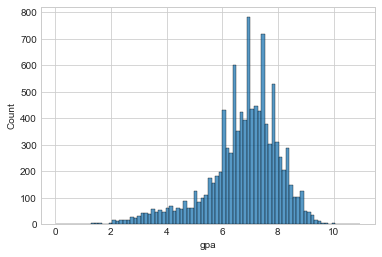

In [171]:
sns.histplot(x="gpa",data=school_final)
school_final[school_final.gpa==10.952380]


In [172]:
#define function that plots the data for each school
def hist_school(dataset,variable):
    sns.histplot(x=variable,data=dataset)

In [173]:
#create widget to make interactive plot
widgets.interact(hist_school,
                 dataset = widgets.fixed(school_final),
                 
                 variable = widgets.Dropdown(description='Variable',  
                                                 options = ['socioeconomic', 'well-being','absence', 'class']));

interactive(children=(Dropdown(description='Variable', options=('socioeconomic', 'well-being', 'absence', 'cla…

### Municiaplity data

In [174]:
merged.describe()

,gpa,highly_educ,avg_income
count,97.000000,97.000000,97.000000
mean,6.712182,0.084646,338204.659794
std,0.531002,0.062595,61721.295533
min,5.599481,0.024623,273927.000000
25%,6.281505,0.045683,305855.000000
50%,6.677767,0.062528,323003.000000
75%,7.005782,0.099227,341632.000000
max,8.271429,0.308710,663328.000000


**Comment on results**

In [175]:
#define function that plots the data for each school
def hist_municipality(dataset,variable):
    sns.histplot(x=variable,data=dataset)

In [176]:
#create widget to make interactive plot
widgets.interact(hist_municipality,
                 dataset = widgets.fixed(merged),
                 variable = widgets.Dropdown(description='Variable',  
                                                 options = ['gpa','avg_income', 'highly_educ']));

interactive(children=(Dropdown(description='Variable', options=('gpa', 'avg_income', 'highly_educ'), value='gp…

## Heat map for the Danish Municipalities 

**To create the the heat map we import a shape file called KOM_MULTIPART**

In [177]:
#reading shp file with map data
map_df = gpd.read_file("KOM_MULTIPART.shp")
merged_munis = merged.municipality.unique() #finding unique municipalities in our data
map_munis = map_df.KOMNAVN.unique() #finding unique municipalities in the map data

# List of municipalities in merged_munis that are named different our map data and the opposite

#finding the difference 
diff1 = [muni for muni in merged_munis if muni not in map_munis] 
diff2 = [muni for muni in map_munis if muni not in merged_munis] 

print(f'Municipalities in our merged data but named differently in the map data: {diff1}')
print(f'Municipalities in our map data but named differently in merged data: {diff2}')

Municipalities in our merged data but named differently in the map data: ['Copenhagen', 'Høje-Taastrup']
Municipalities in our map data but named differently in merged data: ['København', 'Læsø', 'Christiansø', 'Høje Taastrup']


In [ ]:
#creating a copy
merged2 = merged.copy()

# Changing municipality names so the files can merge
merged2.loc[merged2.municipality=='Copenhagen', 'municipality'] = 'København'
merged2.loc[merged2.municipality=='Høje-Taastrup', 'municipality'] = 'Høje Taastrup'

#changing types on the variables
merged2["highly_educ"] = merged2["highly_educ"].astype(str)
merged2["gpa"] = merged2["gpa"].astype(str)
merged2["avg_income"] = merged2["avg_income"].astype(str)

#removing columns so we only keep municipality, lifespan and income columns 
merged_map2 = merged2[['municipality','gpa', 'highly_educ', 'avg_income']]

#merging the map data with the dst data
final_map = pd.merge(map_df, merged_map2, how='left', left_on='KOMNAVN', right_on='municipality')

#Dropping missing values 
final_map = final_map.dropna()


## The variables to be visualized
VisVargpa = 'gpa'
VisVarhigh = 'highly_educ'
VisVarinc = 'avg_income'


# set the colour range in the plot, the possible min and max values
vminUNE, vmaxUNE = merged2['gpa'].min() , merged2['gpa'].max()
vminFer, vmaxFer = merged2['avg_income'].min() , merged2['avg_income'].max()
vminMer, vmaxMer = merged2['highly_educ'].min() , merged2['highly_educ'].max()


######################################## Average GPA ##########################################


# create figure, axes, size, remove whitespace and align the size of the figures in Matplotlib
side_length = 10
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(side_length * 2.1, side_length) , subplot_kw={'aspect': 1})
fig.subplots_adjust(hspace=0.0, wspace=0.0)

# removing axis from our map
ax1.axis('off')
ax2.axis('off')

# add title and size of title
ax1.set_title('Grade point average 2019', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

## create the actual plot
ax1=final_map.plot(column=VisVargpa,  cmap='OrRd', ax=ax1, edgecolor='0.8')

## mapping the colour scale
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vminUNE, vmax=vmaxUNE))

# Empty array
sm._A = []

# create colour bar
cbar = fig.colorbar(sm)

# colour bar title
cbar.ax.set_title('gpa')

#show plot
plt.show()


######################################## Average Income ##########################################


# create figure, axes, size, remove whitespace and align the size of the figures in Matplotlib
side_length = 10
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(side_length * 2.1, side_length) , subplot_kw={'aspect': 1})
fig.subplots_adjust(hspace=0.0, wspace=0.0)

# removing axis from our map
ax1.axis('off')
ax2.axis('off')

# add title and size of title
ax1.set_title('Average Income 2019', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

## create the actual plot
ax1=final_map.plot(column=VisVarinc,  cmap='OrRd', ax=ax1, edgecolor='0.8')

## mapping the colour scale
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vminFer, vmax=vmaxFer))

# Empty array
sm._A = []

# create colour bar
cbar = fig.colorbar(sm)

# colour bar title
cbar.ax.set_title('Average Income')

#show plot
plt.show()


######################################## Share of highly educated ##########################################


# create figure, axes, size, remove whitespace and align the size of the figures in Matplotlib
side_length = 10
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(side_length * 2.1, side_length) , subplot_kw={'aspect': 1})
fig.subplots_adjust(hspace=0.0, wspace=0.0)

# removing axis from our map
ax1.axis('off')
ax2.axis('off')

# add title and size of title
ax1.set_title('Share of highly educated 2019', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

## create the actual plot
ax1=final_map.plot(column=VisVarhigh,  cmap='OrRd', ax=ax1, edgecolor='0.8')

## mapping the colour scale
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vminMer, vmax=vmaxMer))

# Empty array
sm._A = []

# create colour bar
cbar = fig.colorbar(sm)

# colour bar title
cbar.ax.set_title('Percentage')

#show plot
plt.show()

If we look at the three different heat maps we can se that there is a overall tendency for the municipalities in North Sealand and Central Jutland to score highest on gpa, educational level and income level. 

## Correlation

### School data

In [ ]:
#define function that plots the data for each school
def plot_school(dataset,variable):
    ax = sns.regplot(y=variable, x="gpa",data=dataset, scatter_kws={"s": 30}, line_kws={"color": "black"})
    plt.title("Scatterplot")
    plt.xlabel("gpa")
    plt.ylabel(variable)

In [ ]:
#create widget to make interactive plot
widgets.interact(plot_school,
                 dataset = widgets.fixed(school_final),
                 variable = widgets.Dropdown(description='Variable',  
                                                 options = ['socioeconomic', 'well-being','absence', 'class']));

In [ ]:
merged.head(5)
merged.corr(method="pearson")

**Comments**

**Comments**

### Municipality data

Correlation between income and gpa, educ and gpa and well-being

In [ ]:
#define function that plots the data for each school
def plot_kommune(dataset,variable):
    ax = sns.regplot(y=variable, x="gpa",data=dataset, scatter_kws={"s": 30}, line_kws={"color": "black"})
    plt.title("Scatterplot")
    plt.xlabel("gpa")
    plt.ylabel(variable)

In [ ]:
#create widget to make interactive plot
widgets.interact(plot_kommune,
                 dataset = widgets.fixed(merged),
                 variable = widgets.Dropdown(description='Variable',  
                                                 options = ['avg_income', 'highly_educ']));

In [ ]:
school_final.corr(method="pearson")

**Comments**

# Conclusion

**Main results of data analysis**